In [4]:
using LinearAlgebra  #####Son las paqueterias que uso, para instalar una paqueteria basta colocar Pkg.add("Nombre_de_la_paqueteria")
using Plots
using SpecialFunctions: gamma
using Random, Distributions
using StatsBase
using Alert

In [5]:
function OUH(x0::Float64,γ::Float64,t::AbstractArray,Δt::Float64,η::Float64,cte::Float64=0.0) #Proceso de Ornstein–Uhlenbeck
    x=Vector{Float64}(undef, length(t)) #Definimos un vector lleno de basura para luego sobre escribir en el 
    x[1]=x0    #La primera entrada es la condicion inicial del Proceso de Ornstein–Uhlenbeck
    
    for i=1:length(t)-1                 #Usamos un for para poder hacer el proceso
        x0=x0-γ*Δt*(x0-cte)+(sqrt(2*η*Δt)*randn()) # Es el proceso de Ornstein–Uhlenbeck que depende del paso anterior 
        @inbounds x[1+i]=x0                 #@inbounds ignora si la lista tiene el tamaño adecuado y sobreescribimos en la lista basura
    end
    return x                          # Devolvemos la caminata de Ornstein–Uhlenbeck
end

OUH (generic function with 2 methods)

In [6]:
U(K::Float64,T::Float64)=[T/sqrt(K^2+T^2),0,K/sqrt(K^2+T^2)] #Es la función que da el eje de rotación dependiente de la curvatura y la torsión
ϕ(K::Float64,T::Float64,Δt::Float64)=Δt*sqrt(K^2+T^2) #Es la función que da el angulo de rotación

ψ0(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w)) # Es la función para generar el primer angulo  resultado de dos "matrices/cuaternios"

# Son las funciones para generar el primer eje resultado de dos "matrices/cuaternios"
w1x(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1])*csc(ψ0/2) 
w1y(ϕ0,ϕ1,u,w,ψ0)=((u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
w1z(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3])*csc(ψ0/2)


ψn(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w)) # Es la función para generar los otros angulos

# Son las funciones para generar los otros ejes resultado
wnx(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1]-(w[2]*u[3])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)
wny(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[2]+(u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
wnz(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3]+(w[2]*u[1])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)


wnz (generic function with 1 method)

In [7]:
#Acomodamos el eje y el angulo de rotacion en una matriz de euler-rodriguez

MatRot(ω,Ψ)=[ cos(Ψ)+ω[1]^2*(1-cos(Ψ)) ω[1]*ω[2]*(1-cos(Ψ))-ω[3]*sin(Ψ) ω[1]*ω[3]*(1-cos(Ψ))+ω[2]*sin(Ψ);
                ω[2]*ω[1]*(1-cos(Ψ))+ω[3]*sin(Ψ) cos(Ψ)+ω[2]^2*(1-cos(Ψ)) ω[2]*ω[3]*(1-cos(Ψ))-ω[1]*sin(Ψ);
                    ω[3]*ω[1]*(1-cos(Ψ))-ω[2]*sin(Ψ) ω[3]*ω[2]*(1-cos(Ψ))+ω[1]*sin(Ψ) cos(Ψ)+ω[3]^2*(1-cos(Ψ))]

MatRot (generic function with 1 method)

In [8]:
function Trayectoria_r(Δt::Float64,t::AbstractArray,ω::Array{Array{Float64,1},1},Ψ::Array{Float64,1})
    #T=ones(2001)*5
    #K=ones(2001)*5

    #T_v0=(eigen2(2,K,T,Δt).vectors)[:,1]      #Es el vector tangente inicial
    #N_v0=(eigen2(2,K,T,Δt).vectors)[:,2]*im   #Es el vector tangente inicial
    #B_v0=(eigen2(2,K,T,Δt).vectors)[:,3]      #Es el vector tangente inicial
    T_v0=[1.0,0.0,0.0]     #Es el vector tangente inicial
    N_v0=[0.0,1.0,0.0]   #Es el vector tangente inicial
    B_v0=[0.0,0.0,1.0]      #Es el vector tangente inicial
    ##########################################
    T_v=Array{Float64,1}[]       #Lista vacia para todos los vectores tangentes
    for i=1:length(t)                 #For que dura todos los pasos de tiempo
        T_v1=MatRot(ω[i],Ψ[i])*T_v0      #Genera todos los vecotres tangentes a partir del inicial
        push!(T_v,real(T_v1))    #Coloca los vectores tangentes en una lista
    end
    T_v=transpose(hcat(T_v...))     #Transforma T en algo mejor
    ##########################################
    Tx=T_v[:,1]
    Ty=T_v[:,2]
    Tz=T_v[:,3]
    ##########################################
    rx=Float64[]
    ry=Float64[]
    rz=Float64[]
    r1x=randn()
    r1y=randn()
    r1z=randn()
    for i=1:length(t)
        r1x=Tx[i]*Δt+r1x
        r1y=Ty[i]*Δt+r1y
        r1z=Tz[i]*Δt+r1z
        push!(rx,r1x)
        push!(ry,r1y)
        push!(rz,r1z)
    end
    r=[rx,ry,rz]
    return r
end


Trayectoria_r (generic function with 1 method)

In [9]:
function Trayectoria_qua_sol_r(K::AbstractArray,T::AbstractArray,t::AbstractArray,Δt::Float64)
    Un=U.(K,T)
    ϕn=ϕ.(K,T,Δt)
    PASO=length(t)

    ω=Array{Array{Float64,1},1}(undef,PASO)
    Ψ=Array{Float64,1}(undef,PASO)
    ω[1]=Un[1]
    Ψ[1]=ϕn[1]

    ψ1=ψ0(ϕn[1],ϕn[2],Un[1],Un[2])
    w=[w1x(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
        w1y(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
        w1z(ϕn[1],ϕn[2],Un[2],Un[1],ψ1)];
    ω[2]=w
    Ψ[2]=ψ1
    for i=3:PASO
        ψ=ψn(ψ1,ϕn[i],Un[i],w)
        w=[wnx(ψ1,ϕn[i],Un[i],w,ψ),wny(ψ1,ϕn[i],Un[i],w,ψ),wnz(ψ1,ϕn[i],Un[i],w,ψ)]
        ω[i]=w
        Ψ[i]=ψ1
        ψ1=ψ
    end
    
    r=Trayectoria_r(Δt,t,ω,Ψ)
    
    return r
end

Trayectoria_qua_sol_r (generic function with 1 method)

In [10]:
k0=abs(rand(Normal(2,1)))
t0=randn()

γK=abs(rand(Normal(2,1)))
γT=abs(rand(Normal(2,1)))

ηK=abs(rand(Normal(2,1)))
ηT=abs(rand(Normal(2,1)))

N=20.0

Δt=0.001

t=0:Δt:N

ctek=rand(Normal(4,0.5))
ctet=rand(Normal(0,5))


K=OUH(k0,γK,t,Δt,ηK,ctek)
T=OUH(t0,γT,t,Δt,ηT,ctet)
@time r=Trayectoria_qua_sol_r(K,T,t,Δt);

  0.807910 seconds (2.60 M allocations: 119.613 MiB, 4.57% gc time)


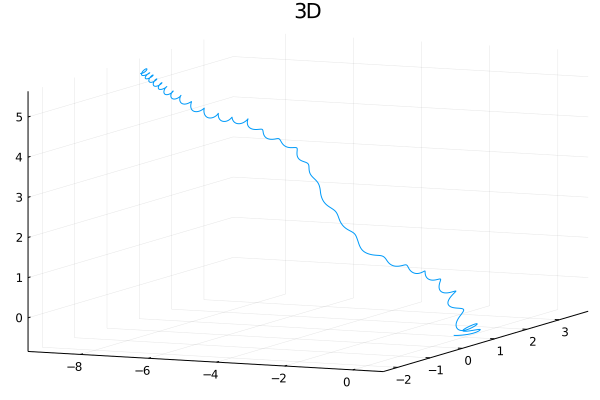

In [24]:
plot(r[1],r[2],r[3], legend=false,title="3D",aspect_ratio=:equal)


In [25]:
@time begin 
for i=1:5
    k0=abs(rand(Normal(2,1)))
    t0=randn()

    γK=abs(rand(Normal(2,1)))
    γT=abs(rand(Normal(2,1)))

    ηK=abs(rand(Normal(2,1)))
    ηT=abs(rand(Normal(2,1)))

    N=20.0

    Δt=0.001

    t=0:Δt:N

    ctek=rand(Normal(4,0.5))
    ctet=rand(Normal(0,5))


    K=OUH(k0,γK,t,Δt,ηK,ctek)
    T=OUH(t0,γT,t,Δt,ηT,ctet)
    r=Trayectoria_qua_sol_r(K,T,t,Δt);
    plot!(r[1],r[2],r[3], legend=false,title="3D",aspect_ratio=:equal)
end
k0=abs(rand(Normal(2,1)))
t0=randn()

γK=abs(rand(Normal(2,1)))
γT=abs(rand(Normal(2,1)))

ηK=abs(rand(Normal(2,1)))
ηT=abs(rand(Normal(2,1)))

N=20.0

Δt=0.001

t=0:Δt:N

ctek=rand(Normal(4,0.5))
ctet=rand(Normal(0,5))


K=OUH(k0,γK,t,Δt,ηK,ctek)
T=OUH(t0,γT,t,Δt,ηT,ctet)
r=Trayectoria_qua_sol_r(K,T,t,Δt);
plot!(r[1],r[2],r[3], legend=false,title="3D",aspect_ratio=:equal,xlabel="x",ylabel="y",zlabel="z");
end

  0.356014 seconds (4.09 M allocations: 146.388 MiB, 2.60% gc time)


In [21]:
savefig("./ENSAMBLE_BONITO")